In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.experimental import enable_iterative_imputer
import re

In [2]:
car_details_v3 = pd.read_csv('../datasets/Car details v3.csv')

In [3]:
car_details_v3[['make', 'model']] = car_details_v3['name'].str.split(' ', n=1, expand=True)

In [4]:
def impute_mileage_with_equivalent_car(df):
  for idx, row in df[df['mileage'] == '0.0 kmpl'].iterrows():
    similar_condition = (df['name'] == row['name']) & (df['year'] == row['year']) & (df['fuel'] == row['fuel'])
    similar_vehicles = df[similar_condition]

    if not similar_vehicles.empty:
      df.at[idx, 'mileage'] = similar_vehicles['mileage'].iloc[0]
  return df

car_details_v3['mileage'] = impute_mileage_with_equivalent_car(car_details_v3)['mileage']

In [5]:
def convert_to_kmpl(row):
    kmpl_rx = r"(\d*\.?\d+)\s*(kmpl)"
    kmkg_rx = r"(\d*\.?\d+)\s*(km/kg)"

    conversion_factor = 1.39

    mileage_value = None

    # Si el fuel es Diesel o Petrol y tiene kmpl, simplemente extraemos el número
    if row['fuel'].lower() in ['diesel', 'petrol']:
        match = re.search(kmpl_rx, row['mileage'])
        if match:
            mileage_value = float(match.group(1))

    # Si el fuel es CNG o LPG y tiene km/kg, convertimos a kmpl
    elif row['fuel'].lower() in ['cng', 'lpg']:
        match = re.search(kmkg_rx, row['mileage'])
        if match:
            kmkg_value = float(match.group(1))
            mileage_value = kmkg_value * conversion_factor  # Convertimos a kmpl

    return mileage_value

mileage_non_null = car_details_v3[car_details_v3['mileage'].notnull()].copy()
car_details_v3['mileage_kmpl'] = mileage_non_null.apply(convert_to_kmpl, axis=1)
car_details_v3.drop(columns=['mileage'])
car_details_v3

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,make,model,mileage_kmpl
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,23.40
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0,Skoda,Rapid 1.5 TDI Ambition,21.14
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0,Honda,City 2017-2020 EXi,17.70
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0,Hyundai,i20 Sportz Diesel,23.00
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0,Maruti,Swift VXI BSIII,16.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85 bhp,113.7Nm@ 4000rpm,5.0,Hyundai,i20 Magna,18.50
8124,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110 bhp,"24@ 1,900-2,750(kgm@ rpm)",5.0,Hyundai,Verna CRDi SX,16.80
8125,Maruti Swift Dzire ZDi,2009,382000,120000,Diesel,Individual,Manual,First Owner,19.3 kmpl,1248 CC,73.9 bhp,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire ZDi,19.30
8126,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70 bhp,140Nm@ 1800-3000rpm,5.0,Tata,Indigo CR4,23.57


In [6]:
def impute_max_power_with_equivalent_car(df):
  for idx, row in df[(df['max_power'].isin(['bhp', '0']))].iterrows():
    similar_condition = (df['name'] == row['name']) & (df['year'] == row['year']) & (df['fuel'] == row['fuel'])
    similar_vehicles = df[similar_condition]

    if not similar_vehicles.empty:
      df.at[idx, 'max_power'] = similar_vehicles['max_power'].iloc[0]
  return df

car_details_v3['max_power'] = impute_max_power_with_equivalent_car(car_details_v3)['max_power']

In [7]:
count_not_null_no_cc = car_details_v3[(car_details_v3['engine'].notnull()) & ~np.array(car_details_v3['engine'].str.contains('CC', case=False), dtype=bool)].shape[0]

print("Number of rows with non-null 'engine' values and no 'CC':", count_not_null_no_cc)

Number of rows with non-null 'engine' values and no 'CC': 0


In [8]:
count_not_null_no_bhp = car_details_v3[(car_details_v3['max_power'].notnull()) & ~np.array(car_details_v3['max_power'].str.contains('bhp', case=False), dtype=bool)].shape[0]

print("Number of rows with non-null 'max_power' values and no 'bhp':", count_not_null_no_bhp)
car_details_v3.loc[car_details_v3['max_power'] == '0', 'max_power'] = None

count_not_null_no_bhp = car_details_v3[(car_details_v3['max_power'].notnull()) & ~np.array(car_details_v3['max_power'].str.contains('bhp', case=False), dtype=bool)].shape[0]

print("Number of rows with non-null 'max_power' values and no 'bhp':", count_not_null_no_bhp)

Number of rows with non-null 'max_power' values and no 'bhp': 4
Number of rows with non-null 'max_power' values and no 'bhp': 0


In [9]:
engine_non_null = car_details_v3[car_details_v3['engine'].notnull()].copy()
car_details_v3['engine_cc'] = engine_non_null['engine'].str.replace(r'[^0-9.]+', '', regex=True)
car_details_v3['engine_cc'] = pd.to_numeric(car_details_v3['engine_cc'], errors='coerce')

In [10]:
max_power_non_null = car_details_v3[car_details_v3['max_power'].notnull()].copy()
car_details_v3['max_power_bhp'] = mileage_non_null['max_power'].str.replace(r'[^0-9.]+', '', regex=True)
car_details_v3['max_power_bhp'] = pd.to_numeric(car_details_v3['max_power_bhp'], errors='coerce')

In [11]:
car_details_v3 = car_details_v3.drop(columns=['name', 'mileage', 'engine', 'max_power'])

In [12]:
missing_values = car_details_v3.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

Feature: year - Missing values: 0
Feature: selling_price - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: fuel - Missing values: 0
Feature: seller_type - Missing values: 0
Feature: transmission - Missing values: 0
Feature: owner - Missing values: 0
Feature: torque - Missing values: 222
Feature: seats - Missing values: 221
Feature: make - Missing values: 0
Feature: model - Missing values: 0
Feature: mileage_kmpl - Missing values: 221
Feature: engine_cc - Missing values: 221
Feature: max_power_bhp - Missing values: 222


In [13]:
car_details_v3['owner'].unique()

array(['First Owner', 'Second Owner', 'Third Owner',
       'Fourth & Above Owner', 'Test Drive Car'], dtype=object)

In [14]:
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2,
    'Third Owner': 3,
    'Fourth & Above Owner': 4,
    'Test Drive Car': 5
}

car_details_v3['owner'] = car_details_v3['owner'].map(owner_mapping)

In [15]:
car_details_v3

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque,seats,make,model,mileage_kmpl,engine_cc,max_power_bhp
0,2014,450000,145500,Diesel,Individual,Manual,1,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,23.40,1248.0,74.00
1,2014,370000,120000,Diesel,Individual,Manual,2,250Nm@ 1500-2500rpm,5.0,Skoda,Rapid 1.5 TDI Ambition,21.14,1498.0,103.52
2,2006,158000,140000,Petrol,Individual,Manual,3,"12.7@ 2,700(kgm@ rpm)",5.0,Honda,City 2017-2020 EXi,17.70,1497.0,78.00
3,2010,225000,127000,Diesel,Individual,Manual,1,22.4 kgm at 1750-2750rpm,5.0,Hyundai,i20 Sportz Diesel,23.00,1396.0,90.00
4,2007,130000,120000,Petrol,Individual,Manual,1,"11.5@ 4,500(kgm@ rpm)",5.0,Maruti,Swift VXI BSIII,16.10,1298.0,88.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,2013,320000,110000,Petrol,Individual,Manual,1,113.7Nm@ 4000rpm,5.0,Hyundai,i20 Magna,18.50,1197.0,82.85
8124,2007,135000,119000,Diesel,Individual,Manual,4,"24@ 1,900-2,750(kgm@ rpm)",5.0,Hyundai,Verna CRDi SX,16.80,1493.0,110.00
8125,2009,382000,120000,Diesel,Individual,Manual,1,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire ZDi,19.30,1248.0,73.90
8126,2013,290000,25000,Diesel,Individual,Manual,1,140Nm@ 1800-3000rpm,5.0,Tata,Indigo CR4,23.57,1396.0,70.00


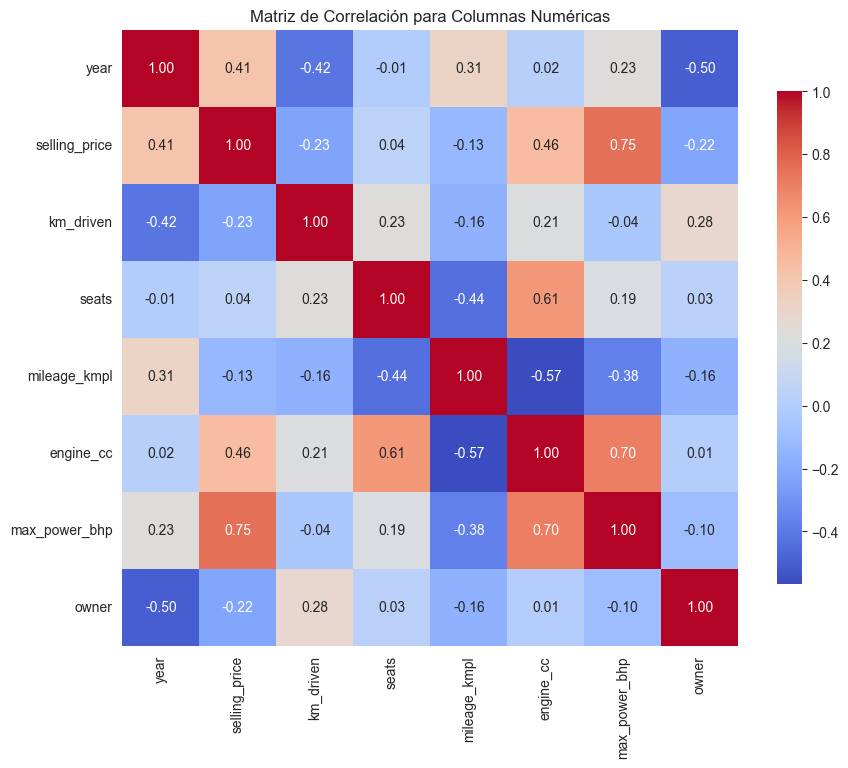

In [16]:
numerical_data = car_details_v3[['year', 'selling_price', 'km_driven', 'seats', 'mileage_kmpl', 'engine_cc', 'max_power_bhp', 'owner']]

# Calcular la matriz de correlación
correlation_matrix = numerical_data.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear el mapa de calor
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Añadir título
plt.title('Matriz de Correlación para Columnas Numéricas')

# Mostrar el gráfico
plt.show()

In [17]:
numerical_cols = ['year', 'selling_price', 'km_driven', 'owner', 'seats', 'mileage_kmpl', 'engine_cc', 'max_power_bhp']
categorical_cols = ['fuel', 'seller_type', 'transmission', 'make']

encoder = OneHotEncoder(drop='first', sparse_output=False)

# Fit and transform the categorical columns
encoded_columns = encoder.fit_transform(car_details_v3[categorical_cols])

encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(categorical_cols))

encoded_df.index = car_details_v3.index
car_details_v3 = pd.concat([car_details_v3.drop(columns=['fuel', 'seller_type', 'transmission']), encoded_df], axis=1)

In [18]:
car_details_v3

,year,selling_price,km_driven,owner,torque,seats,make,model,mileage_kmpl,engine_cc,...,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
0,2014,450000,145500,1,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,23.40,1248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014,370000,120000,2,250Nm@ 1500-2500rpm,5.0,Skoda,Rapid 1.5 TDI Ambition,21.14,1498.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2006,158000,140000,3,"12.7@ 2,700(kgm@ rpm)",5.0,Honda,City 2017-2020 EXi,17.70,1497.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010,225000,127000,1,22.4 kgm at 1750-2750rpm,5.0,Hyundai,i20 Sportz Diesel,23.00,1396.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2007,130000,120000,1,"11.5@ 4,500(kgm@ rpm)",5.0,Maruti,Swift VXI BSIII,16.10,1298.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8123,2013,320000,110000,1,113.7Nm@ 4000rpm,5.0,Hyundai,i20 Magna,18.50,1197.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8124,2007,135000,119000,4,"24@ 1,900-2,750(kgm@ rpm)",5.0,Hyundai,Verna CRDi SX,16.80,1493.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8125,2009,382000,120000,1,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire ZDi,19.30,1248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8126,2013,290000,25000,1,140Nm@ 1800-3000rpm,5.0,Tata,Indigo CR4,23.57,1396.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [19]:
test_split = 0.3
X = car_details_v3.drop(['selling_price'], axis=1)
y = car_details_v3['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)

X_train

,year,km_driven,owner,torque,seats,make,model,mileage_kmpl,engine_cc,max_power_bhp,...,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
6783,2006,120000,3,62Nm@ 3000rpm,5.0,Maruti,Alto LXi BSIII,19.70,796.0,46.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1073,2018,100000,1,450Nm@ 1600-2400rpm,7.0,Toyota,Fortuner 2.8 2WD AT BSIV,12.90,2755.0,174.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7756,2017,39000,1,380Nm@ 1750-2750rpm,5.0,BMW,3 Series 320d GT Luxury Line,19.59,1995.0,187.74,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,2013,39000,1,173Nm@ 4000rpm,5.0,Toyota,Corolla Altis 1.8 G CVT,14.28,1798.0,138.03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6424,2013,70000,2,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,23.40,1248.0,74.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2009,120000,1,290Nm@ 1800-2800rpm,7.0,Mahindra,Scorpio 2006-2009 VLX 2WD 7 Str BSIII,12.05,2179.0,120.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,2014,80000,2,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,23.40,1248.0,74.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,2016,35000,1,114.7Nm@ 4000rpm,5.0,Hyundai,i20 Asta Option 1.2,18.60,1197.0,81.83,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7603,2019,27000,1,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,28.40,1248.0,74.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
data_for_imputation = X_train.drop(['model', 'torque', 'make'], axis=1)

data_for_imputation

,year,km_driven,owner,seats,mileage_kmpl,engine_cc,max_power_bhp,fuel_Diesel,fuel_LPG,fuel_Petrol,...,make_Mitsubishi,make_Nissan,make_Opel,make_Peugeot,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo
6783,2006,120000,3,5.0,19.70,796.0,46.30,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1073,2018,100000,1,7.0,12.90,2755.0,174.50,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7756,2017,39000,1,5.0,19.59,1995.0,187.74,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,2013,39000,1,5.0,14.28,1798.0,138.03,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6424,2013,70000,2,5.0,23.40,1248.0,74.00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2009,120000,1,7.0,12.05,2179.0,120.00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5390,2014,80000,2,5.0,23.40,1248.0,74.00,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
860,2016,35000,1,5.0,18.60,1197.0,81.83,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7603,2019,27000,1,5.0,28.40,1248.0,74.02,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Initialize and fit the imputer
imputer = IterativeImputer(random_state=42, max_iter=10, imputation_order='random')
X_train_imputed = imputer.fit_transform(data_for_imputation)

# Convert the imputed NumPy array back to a DataFrame
X_train_imputed_df = pd.DataFrame(X_train_imputed, columns=data_for_imputation.columns, index=X_train.index)

for column in ['mileage_kmpl', 'engine_cc', 'max_power_bhp', 'seats']:
    X_train[f'{column}_was_imputed'] = X_train[column].isnull()

# Update the original X_train with the imputed values
X_train.update(X_train_imputed_df)

X_train

,year,km_driven,owner,torque,seats,make,model,mileage_kmpl,engine_cc,max_power_bhp,...,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo,mileage_kmpl_was_imputed,engine_cc_was_imputed,max_power_bhp_was_imputed,seats_was_imputed
6783,2006,120000,3,62Nm@ 3000rpm,5.0,Maruti,Alto LXi BSIII,19.70,796.0,46.30,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
1073,2018,100000,1,450Nm@ 1600-2400rpm,7.0,Toyota,Fortuner 2.8 2WD AT BSIV,12.90,2755.0,174.50,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
7756,2017,39000,1,380Nm@ 1750-2750rpm,5.0,BMW,3 Series 320d GT Luxury Line,19.59,1995.0,187.74,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
144,2013,39000,1,173Nm@ 4000rpm,5.0,Toyota,Corolla Altis 1.8 G CVT,14.28,1798.0,138.03,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
6424,2013,70000,2,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,23.40,1248.0,74.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2009,120000,1,290Nm@ 1800-2800rpm,7.0,Mahindra,Scorpio 2006-2009 VLX 2WD 7 Str BSIII,12.05,2179.0,120.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
5390,2014,80000,2,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,23.40,1248.0,74.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
860,2016,35000,1,114.7Nm@ 4000rpm,5.0,Hyundai,i20 Asta Option 1.2,18.60,1197.0,81.83,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
7603,2019,27000,1,190Nm@ 2000rpm,5.0,Maruti,Swift Dzire VDI,28.40,1248.0,74.02,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


In [22]:
missing_values = X_train.isnull().sum()

for column, missing in missing_values.items():
    print(f"Feature: {column} - Missing values: {missing}")

Feature: year - Missing values: 0
Feature: km_driven - Missing values: 0
Feature: owner - Missing values: 0
Feature: torque - Missing values: 152
Feature: seats - Missing values: 0
Feature: make - Missing values: 0
Feature: model - Missing values: 0
Feature: mileage_kmpl - Missing values: 0
Feature: engine_cc - Missing values: 0
Feature: max_power_bhp - Missing values: 0
Feature: fuel_Diesel - Missing values: 0
Feature: fuel_LPG - Missing values: 0
Feature: fuel_Petrol - Missing values: 0
Feature: seller_type_Individual - Missing values: 0
Feature: seller_type_Trustmark Dealer - Missing values: 0
Feature: transmission_Manual - Missing values: 0
Feature: make_Ashok - Missing values: 0
Feature: make_Audi - Missing values: 0
Feature: make_BMW - Missing values: 0
Feature: make_Chevrolet - Missing values: 0
Feature: make_Daewoo - Missing values: 0
Feature: make_Datsun - Missing values: 0
Feature: make_Fiat - Missing values: 0
Feature: make_Force - Missing values: 0
Feature: make_Ford - Miss

In [23]:
X_train['seats'] = X_train['seats'].round().astype(int)

In [24]:
X_train

,year,km_driven,owner,torque,seats,make,model,mileage_kmpl,engine_cc,max_power_bhp,...,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo,mileage_kmpl_was_imputed,engine_cc_was_imputed,max_power_bhp_was_imputed,seats_was_imputed
6783,2006,120000,3,62Nm@ 3000rpm,5,Maruti,Alto LXi BSIII,19.70,796.0,46.30,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
1073,2018,100000,1,450Nm@ 1600-2400rpm,7,Toyota,Fortuner 2.8 2WD AT BSIV,12.90,2755.0,174.50,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
7756,2017,39000,1,380Nm@ 1750-2750rpm,5,BMW,3 Series 320d GT Luxury Line,19.59,1995.0,187.74,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
144,2013,39000,1,173Nm@ 4000rpm,5,Toyota,Corolla Altis 1.8 G CVT,14.28,1798.0,138.03,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
6424,2013,70000,2,190Nm@ 2000rpm,5,Maruti,Swift Dzire VDI,23.40,1248.0,74.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2009,120000,1,290Nm@ 1800-2800rpm,7,Mahindra,Scorpio 2006-2009 VLX 2WD 7 Str BSIII,12.05,2179.0,120.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
5390,2014,80000,2,190Nm@ 2000rpm,5,Maruti,Swift Dzire VDI,23.40,1248.0,74.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
860,2016,35000,1,114.7Nm@ 4000rpm,5,Hyundai,i20 Asta Option 1.2,18.60,1197.0,81.83,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
7603,2019,27000,1,190Nm@ 2000rpm,5,Maruti,Swift Dzire VDI,28.40,1248.0,74.02,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


In [25]:
# Group by 'make' and calculate missing and non-missing 'torque' values
torque_stats = car_details_v3.groupby('make')['torque'].agg(
    missing_torque=lambda x: x.isnull().sum(),
    non_missing_torque=lambda x: x.notnull().sum()
).reset_index()

# Calculate percentage of missing torque values
torque_stats['percentage_missing'] = (torque_stats['missing_torque'] / 
                                      (torque_stats['missing_torque'] + torque_stats['non_missing_torque'])) * 100

# Display the results
torque_stats.sort_values(by='percentage_missing', ascending=False)

,make,missing_torque,non_missing_torque,percentage_missing
25,Peugeot,1,0,100.000000
7,Fiat,6,41,12.765957
29,Toyota,36,452,7.377049
11,Hyundai,55,1360,3.886926
20,Maruti,81,2367,3.308824
9,Ford,9,388,2.267003
28,Tata,15,719,2.043597
19,Mahindra,14,758,1.813472
3,BMW,2,118,1.666667
27,Skoda,1,104,0.952381


In [26]:
X_train

,year,km_driven,owner,torque,seats,make,model,mileage_kmpl,engine_cc,max_power_bhp,...,make_Renault,make_Skoda,make_Tata,make_Toyota,make_Volkswagen,make_Volvo,mileage_kmpl_was_imputed,engine_cc_was_imputed,max_power_bhp_was_imputed,seats_was_imputed
6783,2006,120000,3,62Nm@ 3000rpm,5,Maruti,Alto LXi BSIII,19.70,796.0,46.30,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
1073,2018,100000,1,450Nm@ 1600-2400rpm,7,Toyota,Fortuner 2.8 2WD AT BSIV,12.90,2755.0,174.50,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
7756,2017,39000,1,380Nm@ 1750-2750rpm,5,BMW,3 Series 320d GT Luxury Line,19.59,1995.0,187.74,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
144,2013,39000,1,173Nm@ 4000rpm,5,Toyota,Corolla Altis 1.8 G CVT,14.28,1798.0,138.03,...,0.0,0.0,0.0,1.0,0.0,0.0,False,False,False,False
6424,2013,70000,2,190Nm@ 2000rpm,5,Maruti,Swift Dzire VDI,23.40,1248.0,74.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,2009,120000,1,290Nm@ 1800-2800rpm,7,Mahindra,Scorpio 2006-2009 VLX 2WD 7 Str BSIII,12.05,2179.0,120.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
5390,2014,80000,2,190Nm@ 2000rpm,5,Maruti,Swift Dzire VDI,23.40,1248.0,74.00,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
860,2016,35000,1,114.7Nm@ 4000rpm,5,Hyundai,i20 Asta Option 1.2,18.60,1197.0,81.83,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
7603,2019,27000,1,190Nm@ 2000rpm,5,Maruti,Swift Dzire VDI,28.40,1248.0,74.02,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
